**Import Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

**Map google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls '/content/drive/MyDrive/Lyme_Data_and_Notebook_Codes'

capstone_project_code_samples.ipynb
carmen_tweets_350k.csv
carmen_tweets_keywords_pos.csv
cleaned_labeled_lyme_tweet.csv
df_cdc_tweets_county_state_year_counts.csv
LD-Case-Counts-by-County-00-19.csv
Lyme_Classify_Model_35k_Tweets_AN_Keywords.ipynb
Lyme_Classify_Model_60k_Tweets_AN_FL_Dr_Keywords.ipynb
Lyme_EDA.ipynb
lyme_places_010110_123121.csv
lyme_tweets_010110_123121.csv
NLP_train.csv


**Transform tweets data into desired data structure**

In [ ]:
df_lyme_tweets = pd.read_csv('/content/drive/MyDrive/Lyme_Data_and_Notebook_Codes/carmen_tweets_keywords_pos.csv')
df_lyme_tweets.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (12) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Unnamed: 0,Unnamed: 0.1,id,text,author_id,public_metrics,created_at,in_reply_to_user_id,conversation_id,reply_settings,source,referenced_tweets,context_annotations,entities,user,user_name,city,state,county,country
0,0,0,20956486280679425,"If chronic wasting disease & Lyme aren't enuf,...",41497253,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2010-12-31T21:36:30.000Z,NaN,20956486280679425,everyone,Twitter Web Client,NaN,NaN,NaN,"{'public_metrics': {'followers_count': 128, 'f...",peak2wave,Virginia Beach,Virginia,Virginia Beach City,United States
1,1,1,20894962665132032,My dog contracted Lyme disease. I have several...,76048819,"{'retweet_count': 1, 'reply_count': 0, 'like_c...",2010-12-31T17:32:01.000Z,NaN,20894962665132032,everyone,TweetDeck,NaN,NaN,"{'annotations': [{'start': 63, 'end': 69, 'pro...","{'public_metrics': {'followers_count': 3088, '...",DrFoxVet,Winston-Salem,North Carolina,Forsyth County,United States
2,8,8,20820073241387009,http://bit.ly/ikrOgy Weird Skin With Chronic L...,119030636,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2010-12-31T12:34:26.000Z,NaN,20820073241387009,everyone,Twitter Web Client,NaN,NaN,NaN,"{'public_metrics': {'followers_count': 47, 'fo...",zeruelb,Jacksonville,Florida,Duval County,United States
3,9,9,20820036151156736,Weird Skin With Chronic Lyme Disease Pictures?...,118625413,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2010-12-31T12:34:18.000Z,NaN,20820036151156736,everyone,Twitter Web Client,NaN,NaN,NaN,"{'public_metrics': {'followers_count': 235, 'f...",aelanekf,Fort Worth,Texas,Tarrant County,United States
4,10,10,20759652782309377,What are the symptoms of lyme disease in a dog...,119004023,"{'retweet_count': 0, 'reply_count': 0, 'like_c...",2010-12-31T08:34:21.000Z,NaN,20759652782309377,everyone,Twitter Web Client,NaN,NaN,NaN,"{'public_metrics': {'followers_count': 40, 'fo...",bbradn,Mesa,Arizona,Maricopa County,United States


In [ ]:
df_lyme_tweets.shape

(179077, 20)

In [ ]:
df_lyme_tweets['created_at']= pd.to_datetime(df_lyme_tweets['created_at'])
df_lyme_tweets_by_year_county_st =  df_lyme_tweets.groupby(['county','state',pd.DatetimeIndex(df_lyme_tweets['created_at']). year]).agg({'id':'count'}).reset_index()
df_lyme_tweets_by_year_county_st.head()

,county,state,created_at,id
0,Abbeville County,South Carolina,2012,1
1,Ada County,Idaho,2010,7
2,Ada County,Idaho,2011,4
3,Ada County,Idaho,2012,9
4,Ada County,Idaho,2013,15


In [ ]:
df_lyme_tweets_by_year_county_st.shape

(7609, 4)

**Transform CDC data into desired data structure**

In [ ]:
df_cdc = pd.read_csv('/content/drive/MyDrive/Lyme_Data_and_Notebook_Codes/LD-Case-Counts-by-County-00-19.csv')
df_cdc.head()

,Ctyname,Stname,STCODE,CTYCODE,Cases2000,Cases2001,Cases2002,Cases2003,Cases2004,Cases2005,Cases2006,Cases2007,Cases2008,Cases2009,Cases2010,Cases2011,Cases2012,Cases2013,Cases2014,Cases2015,Cases2016,Cases2017,Cases2018,Cases2019
0,Autauga County,Alabama,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,1
1,Baldwin County,Alabama,1,3,1,0,1,0,0,0,0,0,0,1,0,1,1,0,3,1,2,2,0,0
2,Barbour County,Alabama,1,5,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
3,Bibb County,Alabama,1,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
4,Blount County,Alabama,1,9,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2,0


In [ ]:

df_cdc_transposed = df_cdc.melt(id_vars=['Ctyname','Stname','STCODE','CTYCODE']).set_axis(['county','state','st_code','cty_code','created_at','count'], axis='columns', inplace=False)
df_cdc_transposed["created_at"] = df_cdc_transposed["created_at"].apply(lambda x: x.replace("Cases", ""))
df_cdc_transposed = df_cdc_transposed[['county','state','created_at','count']]
print('\nTransposed CDC data to the same format as tweets \n')
df_cdc_transposed.head()



Transposed CDC data to the same format as tweets 



,county,state,created_at,count
0,Autauga County,Alabama,2000,0
1,Baldwin County,Alabama,2000,1
2,Barbour County,Alabama,2000,0
3,Bibb County,Alabama,2000,0
4,Blount County,Alabama,2000,0


In [ ]:
print(df_cdc_transposed.shape)

(63860, 4)


**Merging (inner join) CDC and tweets data by county,state and year**

In [63]:
df_cdc_transposed.created_at = df_cdc_transposed.created_at.astype(int)
df_cdc_tweets_county_state_year_counts = pd.merge(df_lyme_tweets_by_year_county_st, df_cdc_transposed, on=['county','state','created_at'], how='inner').set_axis(['county','state','year','tweet_count','cdc_count'], axis='columns', inplace=False)



**Merging (right outer join) CDC and tweets data by county,state and year**

In [31]:
df_cdc_transposed.created_at = df_cdc_transposed.created_at.astype(int)

df_cdc_tweets_county_state_year_counts = pd.merge(df_lyme_tweets_by_year_county_st, df_cdc_transposed, on=['county','state','created_at'], how='outer').set_axis(['county','state','year','tweet_count','cdc_count'], axis='columns', inplace=False)

df_cdc_tweets_county_state_year_counts = df_cdc_tweets_county_state_year_counts.fillna(0)


In [ ]:
df_cdc_tweets_county_state_year_counts.to_csv('/content/drive/MyDrive/Lyme_Data_and_Notebook_Codes/df_cdc_tweets_county_state_year_counts.csv')

In [86]:

def plot_cdc_tweets(year,state,join_type='inner'):

  df_cdc_transposed.created_at = df_cdc_transposed.created_at.astype(int)
  df_cdc_tweets_county_state_year_counts = pd.merge(df_lyme_tweets_by_year_county_st, df_cdc_transposed, on=['county','state','created_at'], how=join_type).set_axis(['county','state','year','tweet_count','cdc_count'], axis='columns', inplace=False)
  df_cdc_tweets_county_state_year_counts = df_cdc_tweets_county_state_year_counts.fillna(0)


  fig, axs = plt.subplots(2, 1,figsize=(15,10))
  fig.suptitle('Tweets and CDC counts side by side for state : '+state+' and year :'+str(year))
  sel_data = df_cdc_tweets_county_state_year_counts[(df_cdc_tweets_county_state_year_counts.year==year) & (df_cdc_tweets_county_state_year_counts.state == state)]
  axs[0].plot("county", "tweet_count", data=sel_data,color = 'b',ls = '--')
  axs[1].plot("county", "cdc_count", data=sel_data,color = 'r',ls = '-.')
  axs[0].set_title('Tweets count by county for state : '+state+' and year :'+str(year))
  axs[1].set_title('CDC count by county for state : '+state+' and year :'+str(year))
  # lst  = df_cdc_tweets_county_state_year_counts[(df_cdc_tweets_county_state_year_counts.year==year) & (df_cdc_tweets_county_state_year_counts.state == state)]['county']
  # axs[0].legend( lst)
  for ax in axs.flat:
      ax.set(xlabel='county', ylabel='count')
      ax.set_xticklabels(ax.get_xticks())

  corr_p, _ = pearsonr(sel_data['tweet_count'], sel_data['cdc_count'])
  print('Pearsons correlation: %.3f' % corr_p)
  corr_s, _ = spearmanr(sel_data['tweet_count'], sel_data['cdc_count'])
  print('Spearman correlation: %.3f' % corr_s)
  # print(lst)

def plot_corr_metrics(state,join_type='inner'):

  df_cdc_transposed.created_at = df_cdc_transposed.created_at.astype(int)
  df_cdc_tweets_county_state_year_counts = pd.merge(df_lyme_tweets_by_year_county_st, df_cdc_transposed, on=['county','state','created_at'], how=join_type).set_axis(['county','state','year','tweet_count','cdc_count'], axis='columns', inplace=False)
  df_cdc_tweets_county_state_year_counts = df_cdc_tweets_county_state_year_counts.fillna(0)

  df = pd.DataFrame(columns = ['state','year','corr_p','corr_s'])

  for year in range(2010,2020,1):
    sel_data = df_cdc_tweets_county_state_year_counts[(df_cdc_tweets_county_state_year_counts.year==year) & (df_cdc_tweets_county_state_year_counts.state == state)]
    corr_p, _ = pearsonr(sel_data['tweet_count'], sel_data['cdc_count'])
    corr_s, _ = spearmanr(sel_data['tweet_count'], sel_data['cdc_count'])
    df = df.append({'state':state,'year':year,'corr_p':corr_p,'corr_s':corr_s},ignore_index = True)

  fig, axs = plt.subplots(1, 1,figsize=(10,8))
  axs.plot("year", "corr_p", data=df,color = 'b',ls = '--')
  axs.set(xlabel='year', ylabel='corr_p')
  plt.axhline(y = 0.5, color = 'r', linestyle = '-.')
  return df





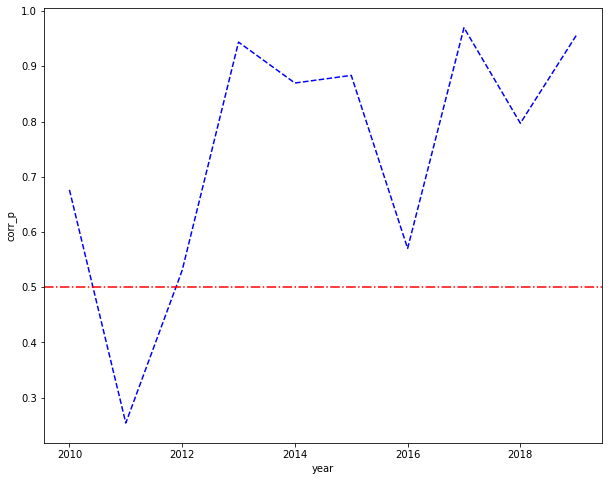

In [87]:
df_corr = plot_corr_metrics('Washington','inner')
# print(df_corr)

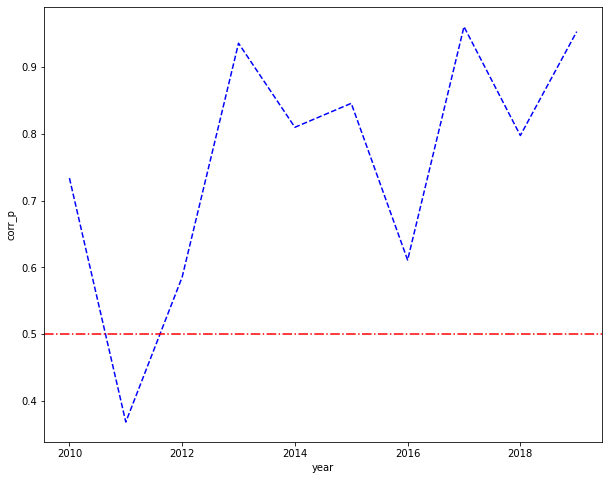

In [88]:
df_corr = plot_corr_metrics('Washington','outer')
# print(df_corr)

Pearsons correlation: 0.884
Spearman correlation: 0.358


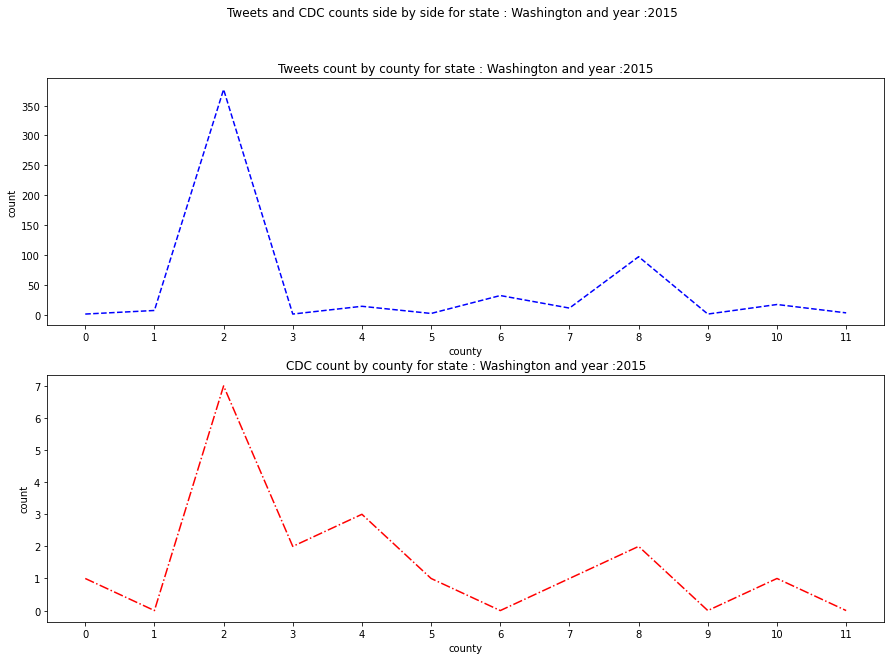

In [89]:
plot_cdc_tweets(2015,'Washington','inner')

Pearsons correlation: 0.845
Spearman correlation: 0.529


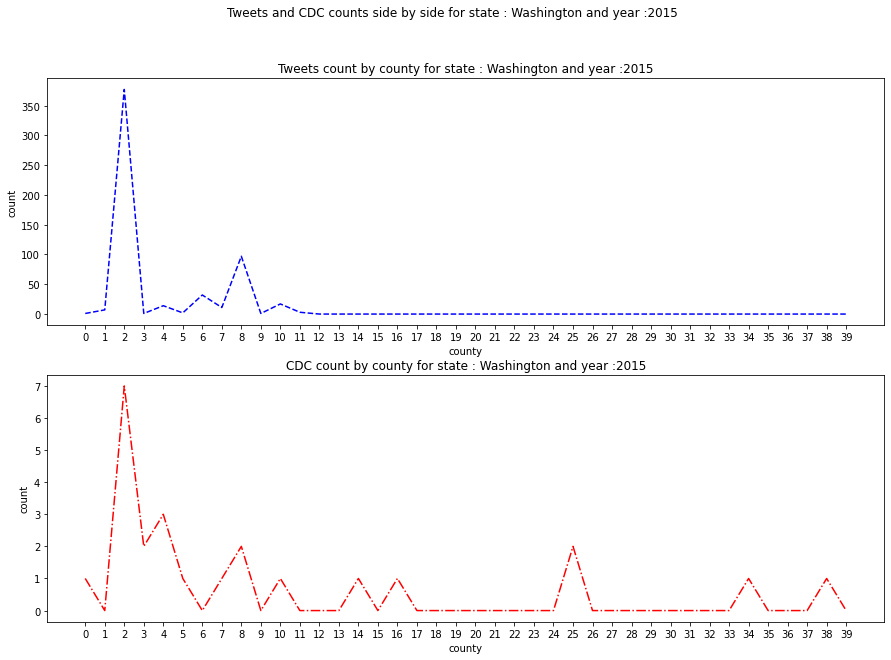

In [90]:
plot_cdc_tweets(2015,'Washington','outer')

In [ ]:
df_cdc_tweets_county_state_year_counts.state.unique()

array(['South Carolina', 'Idaho', 'Kentucky', 'Missouri', 'Colorado',
       'Illinois', 'Mississippi', 'Nebraska', 'Pennsylvania', 'Vermont',
       'Florida', 'North Carolina', 'California', 'New York', 'Wyoming',
       'Michigan', 'Maryland', 'Indiana', 'Ohio', 'Tennessee', 'Maine',
       'Texas', 'Minnesota', 'Virginia', 'Louisiana', 'Wisconsin',
       'New Jersey', 'Alabama', 'Massachusetts', 'Georgia', 'Arkansas',
       'Oregon', 'Washington', 'West Virginia', 'New Mexico', 'Iowa',
       'Rhode Island', 'South Dakota', 'Oklahoma', 'North Dakota',
       'Kansas', 'Utah', 'New Hampshire', 'Nevada', 'Montana', 'Arizona',
       'District of Columbia', 'Alaska', 'Connecticut', 'Hawaii',
       'Delaware'], dtype=object)